## PAMAP2 
##### PAMAP2 (Physical Activity Monitoring 2) 데이터셋은 2012년 독일 인공지능 연구소(DFKI)에서 공개한, 인간의 신체 활동 인식을 위한 데이터셋
- 목적: 3개의 IMU 센서와 1개의 심박수 모니터를 사용해, 9명의 피험자가 수행하는 12가지 활동을 기록.
- 피험자: 9명 (8명의 남성, 1명의 여성.)
- 센서: Colibri IMU (Inertial Measurement Unit) 3개, Polar HxM 심박수 모니터 1개.

##### 실험 설정 및 센서 구성

1. 센서 위치 (총 3개 IMU)
피험자는 3곳에 IMU를 부착했습니다. 이것이 컬럼명(hand_, chest_, ankle_)의 유래입니다.
- 손 (Hand): 주로 사용하는 손의 손목 (시계처럼)
- 가슴 (Chest): 가슴 중앙
- 발목 (Ankle): 주로 사용하는 발의 발목

2. 샘플링 속도 (Sampling Rate)
- IMU (가속도, 자이로, 자기장): 100Hz (1초에 100번 측정)
- 심박수 (Heart Rate): 9Hz (1초에 9번 측정)
    - 두 센서의 측정 주기가 다릅니다. 데이터를 100Hz 기준으로 한 줄로 합치는 과정에서, IMU 데이터 11개당 심박수 데이터 1개가 들어오는 셈
    - 이로 인해 원본 heart_rate 컬럼은 **전체 행의 약 90%가 NaN (결측치)**.

##### 컬럼 상세 (총 54개 컬럼)

1. 기본 정보 (3개)
- `timestamp`: (float) 활동 시작 후 경과 시간 (초).
- `activityID`: (int) 활동 레이블 (타겟 변수). 아래 상세 설명 참조.
- `subjectID`: (int) 피험자 ID (예: 101, 102...).

2. 심박수 (1개)
- `heart_rate`: (float) 심박수 (bpm). 앞서 말했듯 NaN이 대부분임.

3. IMU 센서 데이터 (총 51개 = 17개 * 3위치)
모든 IMU 컬럼은 [위치]_[센서종류]_[축] 명명 규칙을 따릅니다. (예: hand_acc_16g_x, ankle_gyro_z)
- 각 위치(hand, chest, ankle)는 동일하게 17개의 센서 값을 가집니다.
- `_temperature`: (float, 1개) 센서 자체의 온도.
- `_acc_16g_x/y/z`: (float, 3개) 가속도계 (±16g 범위). 물체의 움직임과 중력을 측정.
- `_acc_6g_x/y/z`: (float, 3개) 가속도계 (±6g 범위). 더 민감한 범위.

*16g와 6g 두 개가 같이 있는 건 그냥 **정보 중복(redundancy)*. 둘 중 하나만 써도 무방

- `_gyro_x/y/z`: (float, 3개) 자이로스코프. 물체의 회전 속도 (각속도)를 측정.
- `_mag_x/y/z`: (float, 3개) 지자기센서. 지구 자기장을 기준으로 방향(북/남/동/서)을 측정.
- `_orientation_0/1/2/3`: (float, 4개) 방향 (쿼터니언).

- 이 4개 컬럼은 (w, x, y, z) 쿼터니언(Quaternion) 값으로, 3D 공간에서 센서의 절대적인 자세(방향)를,
3축 각도(Euler angles)보다 수학적으로 안정적이라 사용

##### 타킷변수: `activityID` (총 13개)
```Markdown
ID,Activity Name,설명
0,Transient / Other, '전환 활동' 또는 '기타'.  (예: 앉기에서 일어서는 중). 노이즈(Noise)로 봐야하고 명확한 패턴이 없으므로 모델 학습 시 반드시 제거
1,standing,서 있기
2,sitting,앉아 있기
3,lying,누워 있기
4,walking,걷기
5,cycling,자전거 타기 (실내)
6,running,달리기
7,Nordic walking,노르딕 워킹 (폴대 사용)
12,ascending stairs,계단 오르기
13,descending stairs,계단 내려가기
16,vacuum cleaning,진공청소기 돌리기
17,ironing,다림질하기
24,rope jumping,줄넘기
```

In [1]:
#################################################################################
# Library Import
#################################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#################################################################################
# Load Data 
#################################################################################
df = pd.read_csv("C://Users/sampa/EDA/pamap.csv", index_col=0)
df.head()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,100.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,100.0,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,100.0,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,100.0,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1


In [3]:
#################################################################################
# Data Info
#################################################################################
info_df = pd.DataFrame(df.dtypes, columns=['Dtype'])
info_df = info_df.reset_index().rename(columns={'index': 'Column'})

info_df['Non-Null Count'] = df.count().values
info_df['Null Count'] = df.isnull().sum().values
total_rows = df.shape[0]
print(f"Total Entries (Rows): {total_rows}\n")

info_df

Total Entries (Rows): 2872533



,Column,Dtype,Non-Null Count,Null Count
0,timestamp,float64,2872533,0
1,activityID,int64,2872533,0
2,heartrate,float64,262271,2610262
3,handTemperature,float64,2859392,13141
4,handAcc16_1,float64,2859392,13141
5,handAcc16_2,float64,2859392,13141
6,handAcc16_3,float64,2859392,13141
7,handAcc6_1,float64,2859392,13141
8,handAcc6_2,float64,2859392,13141
9,handAcc6_3,float64,2859392,13141


In [4]:
#################################################################################
# Missing & Anomaly Interpolation
#################################################################################
'''
결측치와 이상치를 제거 등의 일반적인 방식이 아닌 보간법을 사용하는 이유
- 결측치가 포함된 행 전체를 제거하면 Time Series Data에서는 정보 손실이 크다. 
- 일반 데이터는 각 행이 독립적이지만 Time Series Data는 현재시점의 데이터와 이전시점의 
  데이터가 시간적으로 종속적으로 연결되어 있기 때문에 핵심적인 구조를 파괴할 수 있다. 
'''
print(f"\n Before Interpolation: {df['heartrate'].isna().sum()}")

# 1. Linear Interpolation
# ex) 80과 83 사이의 NAN 두 개는 각각 81, 82로 채워짐.
df['heartrate'] = df['heartrate'].interpolate(method='linear')
print(f"\n 1. After Linear Interpolation: {df['heartrate'].isna().sum()}")


# 2. Edge Case
# 만약 NaN으로 시작하거나 NaN으로 끝나면 'linear'방식은 불가능하다.
# 이땐, ffill(앞의 값)이나 bfill(뒤의 값)으로 채워준다. 
df['heartrate'] = df['heartrate'].fillna(method='bfill')
df['heartrate'] = df['heartrate'].fillna(method='ffill')
print(f"\n 2. After ffill/bfill: {df['heartrate'].isna().sum()} ")


 Before Interpolation: 2610262

 1. After Linear Interpolation: 0

 2. After ffill/bfill: 0 


In [ ]:
# Interpolate All Numeric Columns
before_na_count = df.isnull().sum().sum()
print(f"Before Interpolation: {before_na_count:,}")

numeric_cols = df.select_dtypes(include=['float64', 'float32']).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

after_na_count = df.isnull().sum().sum()
print(f"After Interpolation: {after_na_count:,}")

Before Interpolation: 3,093,963 ---
After Interpolation: 0 ---


In [10]:
#################################################################################
# Explore Target
#################################################################################
activity_map = {
    0: 'Transient(Other)',
    1: 'standing',
    2: 'sitting',
    3: 'lying',
    4: 'walking',
    5: 'cycling',
    6: 'running',
    7: 'Nordic walking',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    24: 'rope jumping'
}

activity_counts = df['activityID'].value_counts().sort_index()

activity_counts_df = activity_counts.to_frame(name='Count').reset_index()
activity_counts_df = activity_counts_df.rename(columns={'index': 'Activity ID'})

activity_counts_df['Activity Name'] = activity_counts_df['Activity ID'].map(activity_map)
activity_counts_df = activity_counts_df[['Activity ID', 'Activity Name', 'Count']]
activity_counts_df

,Activity ID,Activity Name,Count
0,0,Transient(Other),929661
1,1,standing,192523
2,2,sitting,185188
3,3,lying,189931
4,4,walking,238761
5,5,cycling,98199
6,6,running,164600
7,7,Nordic walking,188107
8,12,ascending stairs,117216
9,13,descending stairs,104944


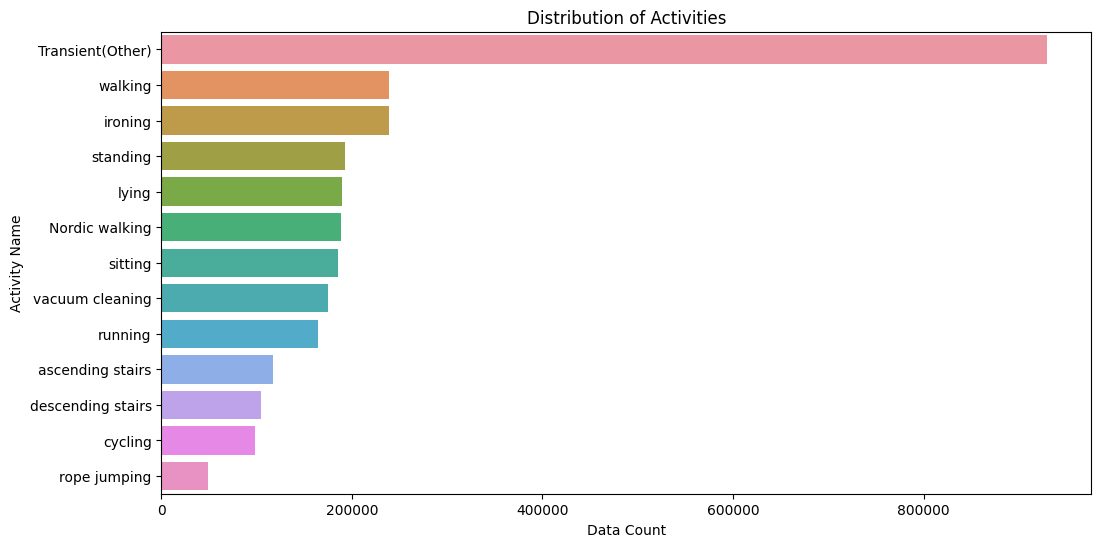

In [ ]:
plot_data = activity_counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Count', 
    y='Activity Name', 
    data=plot_data, 
    orient='h' 
)

plt.title('Distribution of Activities')
plt.xlabel('Data Count') 
plt.ylabel('Activity Name') 
plt.show()

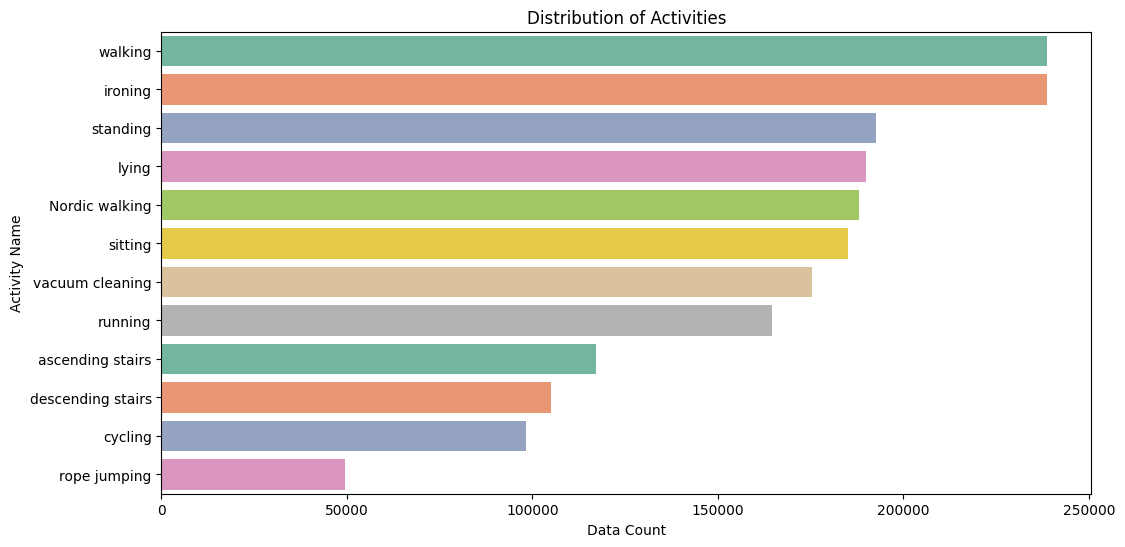

In [18]:
plot_data = plot_data[plot_data['Activity Name'] != 'Transient(Other)']

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Count', 
    y='Activity Name', 
    data=plot_data, 
    orient='h',
    palette='Set2'
)

plt.title('Distribution of Activities')
plt.xlabel('Data Count') 
plt.ylabel('Activity Name') 
plt.show()

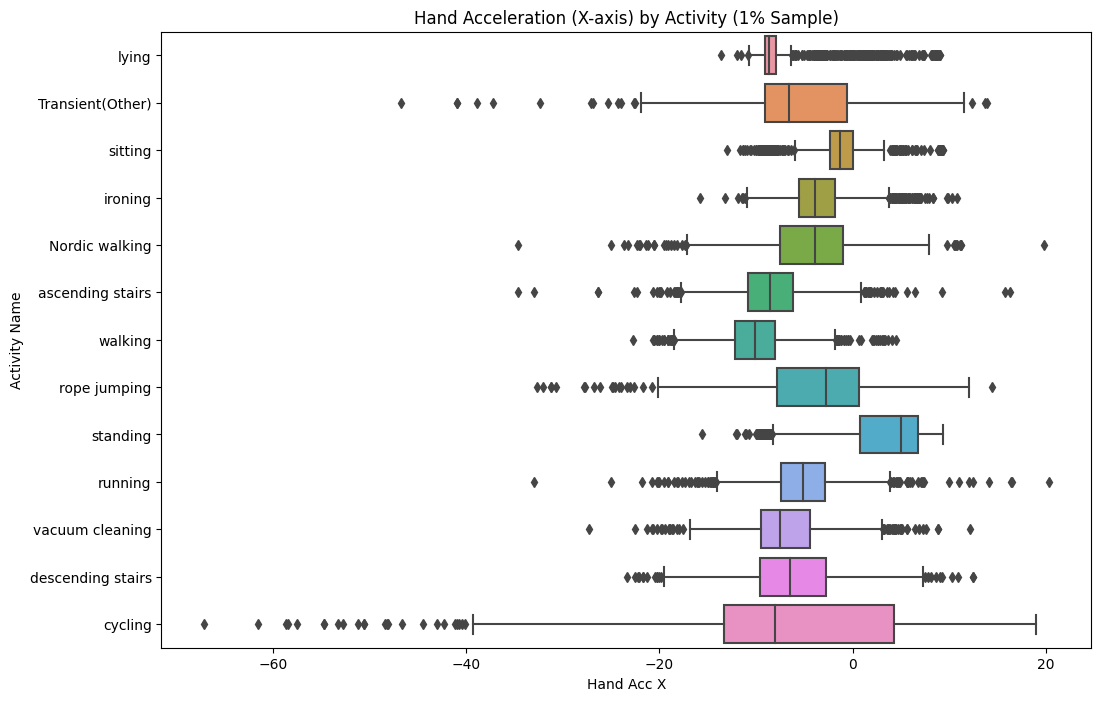

In [28]:
df['activity_name'] = df['activityID'].map(activity_map)
df_sample = df.sample(frac=0.01, random_state=42)

plt.figure(figsize=(12, 8))
sns.boxplot(
    x='handAcc16_1',    # x축: 센서 값
    y='activity_name', # y축: 활동 이름
    data=df_sample,    # 샘플링된 데이터 사용!
    orient='h'         # 수평 그래프
)
plt.title('Hand Acceleration (X-axis) by Activity (1% Sample)')
plt.xlabel('Hand Acc X')
plt.ylabel('Activity Name')
plt.show()

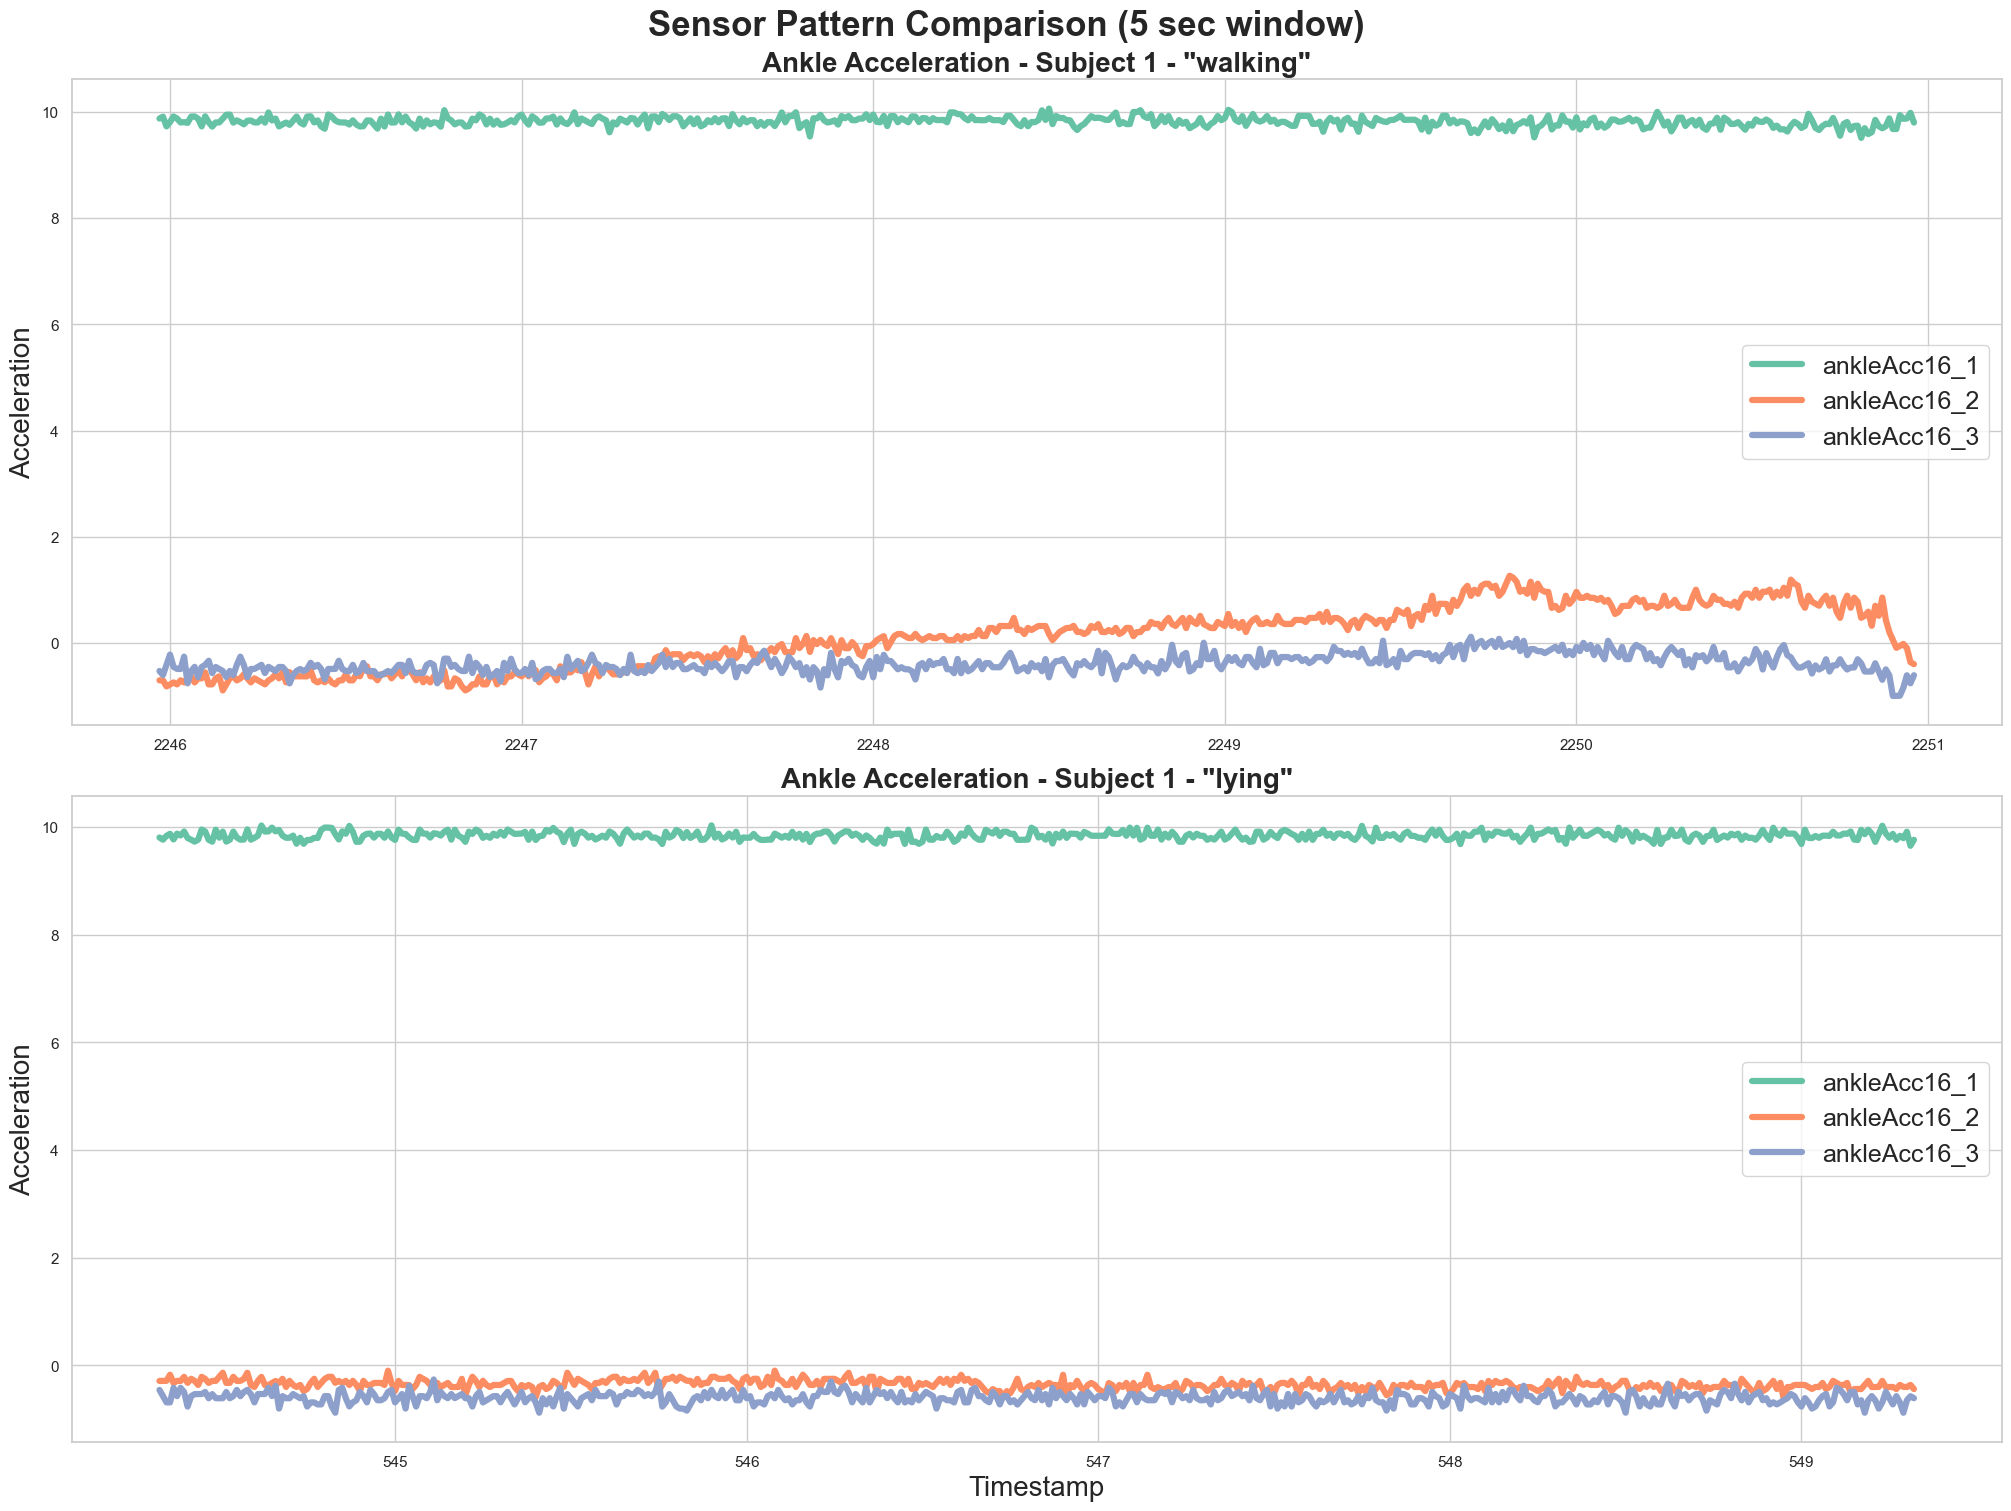

In [60]:
sns.set_theme(style="whitegrid", palette='Set2')
subject_id = 1
sensors_to_plot = ['ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3']

plot_slice_walking = df[
    (df['subject_id'] == subject_id) & 
    (df['activity_name'] == 'walking')
].head(500)

plot_slice_lying = df[
    (df['subject_id'] == subject_id) & 
    (df['activity_name'] == 'lying')
].head(500)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15), constrained_layout=True)
for sensor in sensors_to_plot:
    sns.lineplot(
        x='timestamp', 
        y=sensor, 
        data=plot_slice_walking, 
        label=sensor, 
        linewidth=4.5,
        ax=axes[0] 
    )
axes[0].set_title(f'Ankle Acceleration - Subject {subject_id} - "walking"', fontsize=20, weight='bold')
axes[0].set_xlabel('') 
axes[0].set_ylabel('Acceleration', fontsize=20)
axes[0].legend(fontsize=18)

for sensor in sensors_to_plot:
    sns.lineplot(
        x='timestamp', 
        y=sensor, 
        data=plot_slice_lying, 
        label=sensor, 
        linewidth=4.5,
        ax=axes[1] 
    )
axes[1].set_title(f'Ankle Acceleration - Subject {subject_id} - "lying"', fontsize=20, weight='bold')
axes[1].set_xlabel('Timestamp', fontsize=20)
axes[1].set_ylabel('Acceleration', fontsize=20)
axes[1].legend(fontsize=18)

fig.suptitle('Sensor Pattern Comparison (5 sec window)', fontsize=25, weight='bold')
plt.show()
sns.reset_defaults()

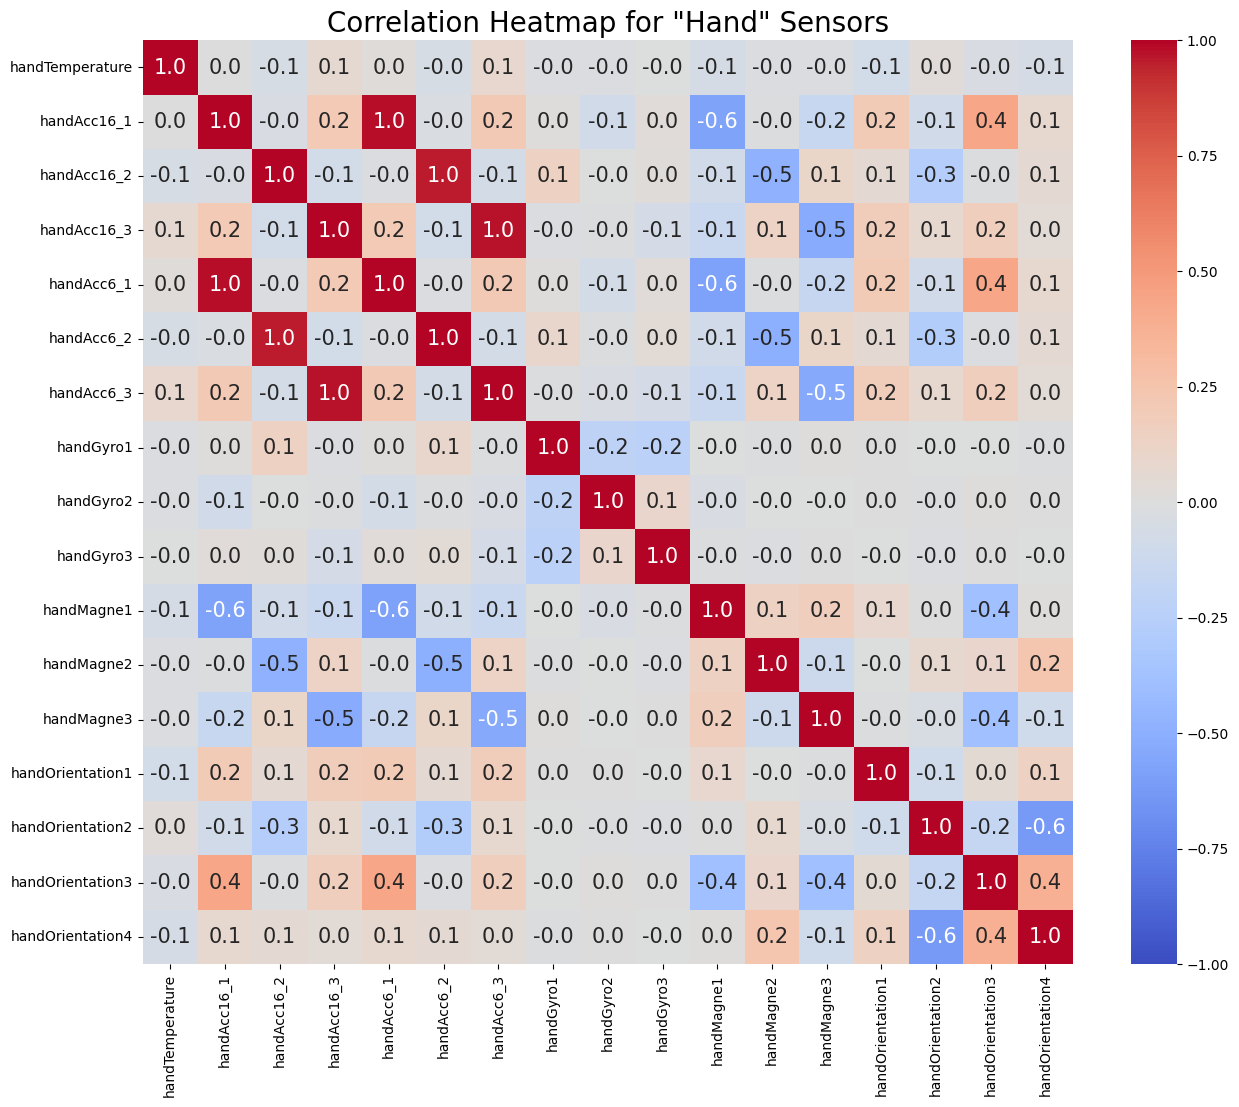

In [63]:
hand_sensors = [col for col in df.columns if col.startswith('hand')]
df_hand = df[hand_sensors]

if len(df_hand) > 50000:
    # 5만 개 샘플링 
    corr_matrix = df_hand.sample(n=50000, random_state=42).corr()
else:
    corr_matrix = df_hand.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,        
    annot_kws={"size": 15}, 
    fmt='.1f',       
    cmap='coolwarm',   
    vmin=-1, vmax=1    
)
plt.title('Correlation Heatmap for "Hand" Sensors', fontsize=20)
plt.show()

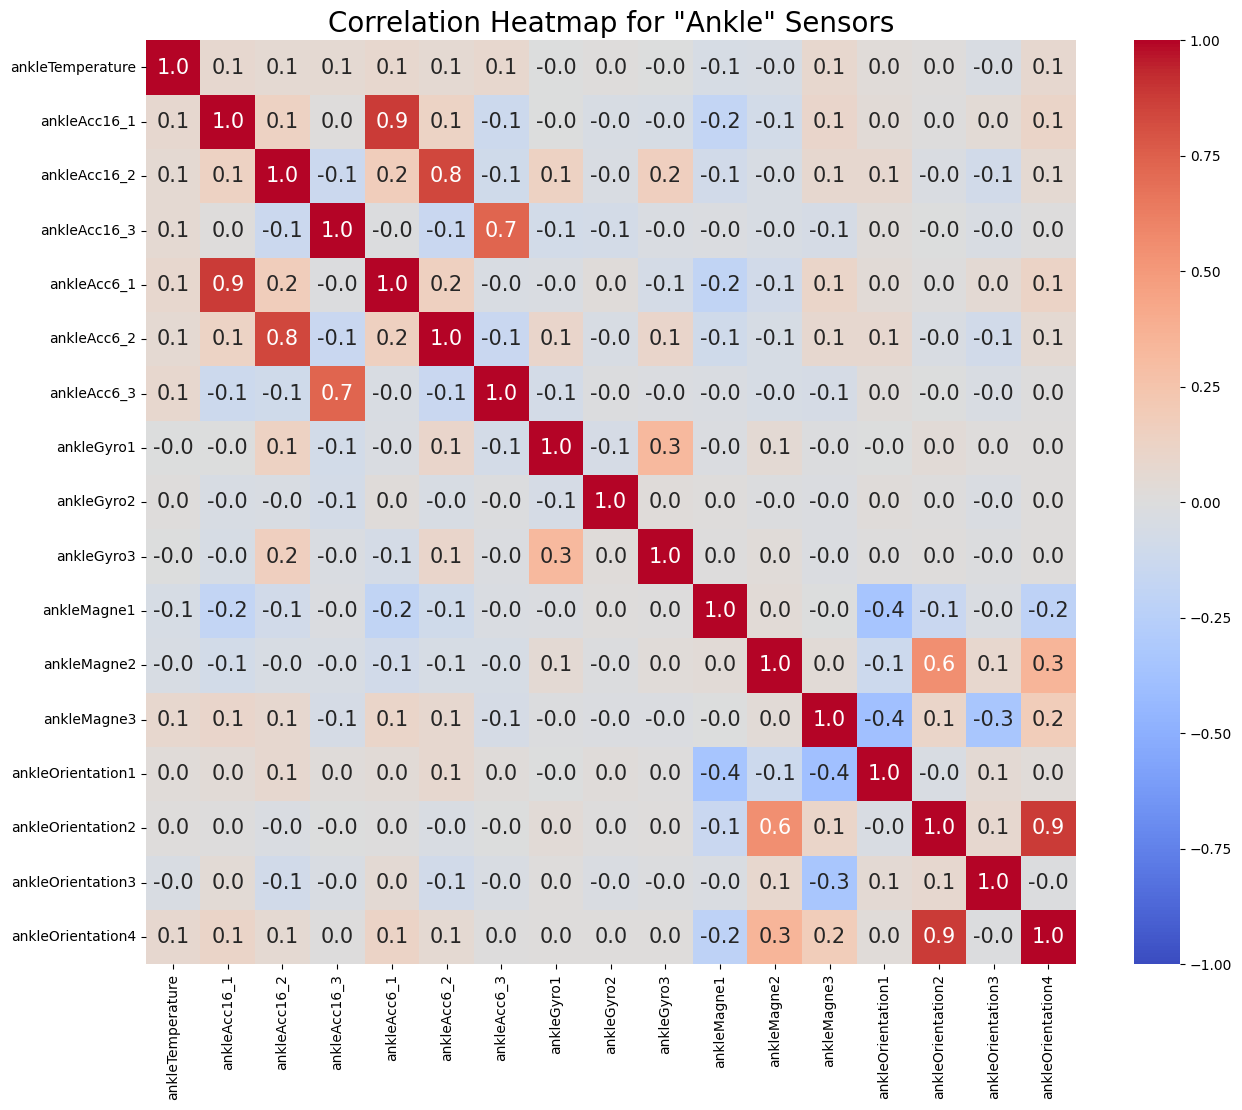

In [64]:
ankle_sensors = [col for col in df.columns if col.startswith('ankle')]
df_ankle = df[ankle_sensors]

if len(df_ankle) > 50000:
    # 5만 개 샘플링 
    corr_matrix = df_ankle.sample(n=50000, random_state=42).corr()
else:
    corr_matrix = df_ankle.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,        
    annot_kws={"size": 15}, 
    fmt='.1f',       
    cmap='coolwarm',   
    vmin=-1, vmax=1    
)
plt.title('Correlation Heatmap for "Ankle" Sensors', fontsize=20)
plt.show()

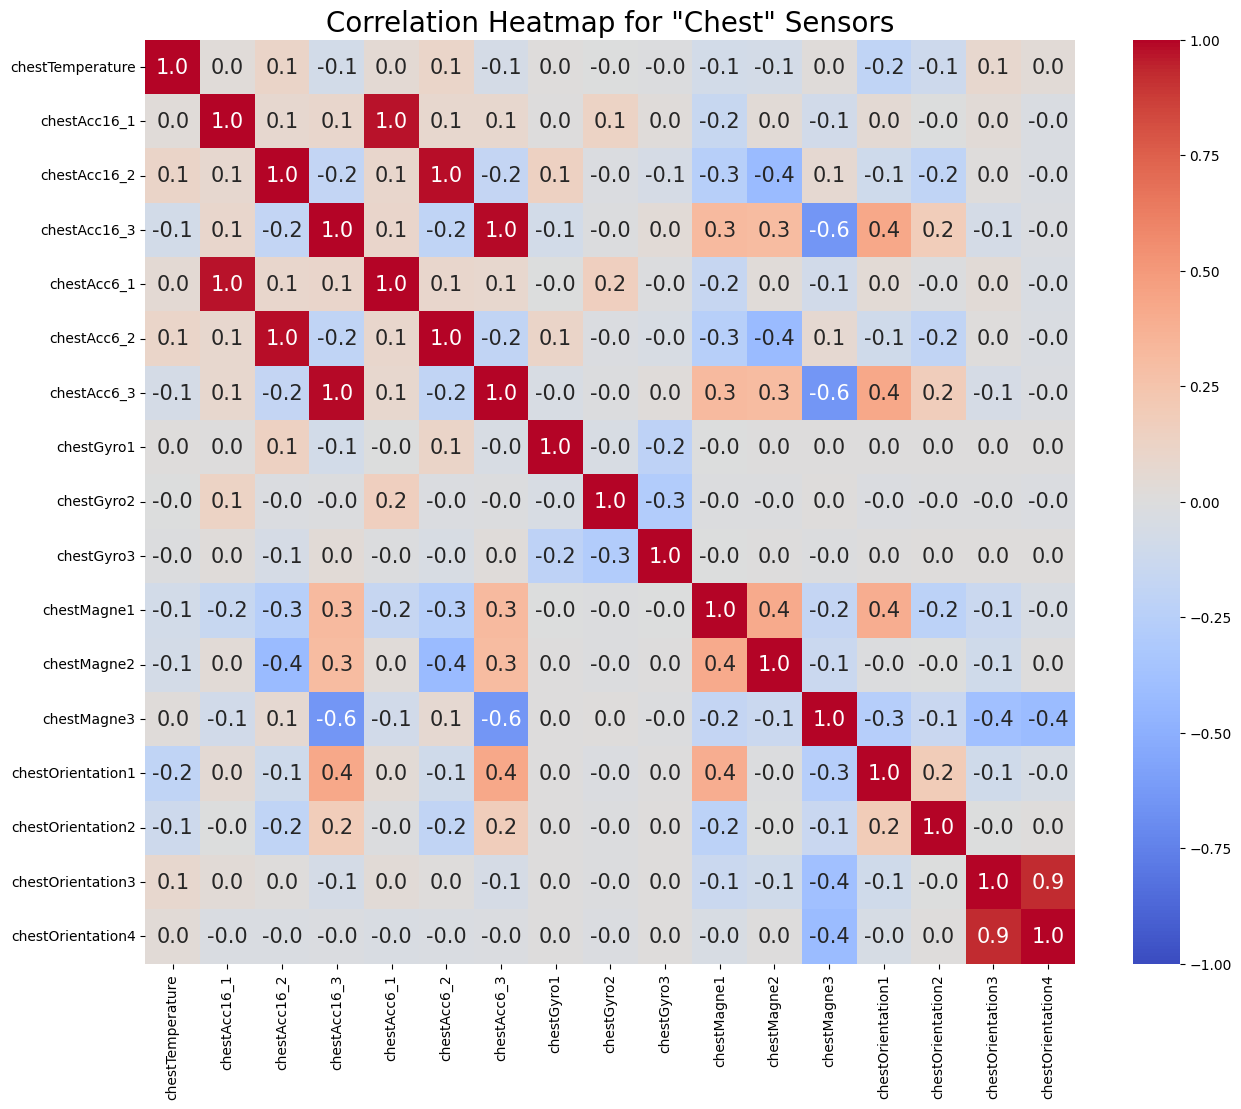

In [65]:
chest_sensors = [col for col in df.columns if col.startswith('chest')]
df_chest = df[chest_sensors]

if len(df_ankle) > 50000:
    # 5만 개 샘플링 
    corr_matrix = df_chest.sample(n=50000, random_state=42).corr()
else:
    corr_matrix = df_chest.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,        
    annot_kws={"size": 15}, 
    fmt='.1f',       
    cmap='coolwarm',   
    vmin=-1, vmax=1    
)
plt.title('Correlation Heatmap for "Chest" Sensors', fontsize=20)
plt.show()

In [70]:
subject_counts = df['subject_id'].value_counts().sort_index()

subject_counts_df = subject_counts.to_frame(name='Count')
subject_counts_df.index.name = 'Subject ID'

print("--- 피험자별 데이터 개수 ---")
subject_counts_df

--- 피험자별 데이터 개수 ---


,Count
Subject ID,
1,376417
2,447000
3,252833
4,329576
5,374783
6,361817
7,313599
8,408031
9,8477


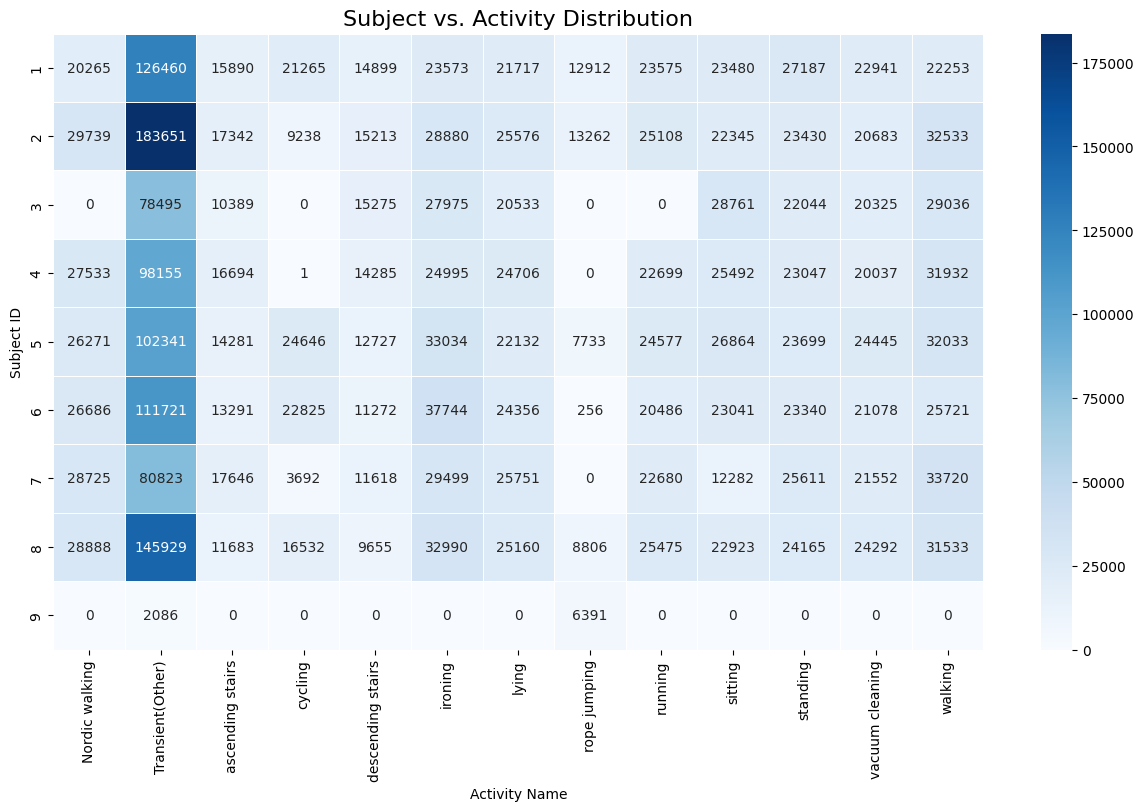

In [ ]:
subject_activity_matrix = df.groupby(['subject_id', 'activity_name']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))
sns.heatmap(
    subject_activity_matrix, 
    annot=True,     
    fmt='d',        
    cmap='Blues', 
    linewidths=.5   
)
plt.title('Subject vs. Activity Distribution', fontsize=16)
plt.xlabel('Activity Name')
plt.ylabel('Subject ID')
plt.show()